# Steam Hardware Survey scraping

Using https://github.com/sangaline/wayback-machine-scraper

### Sources:
- https://web.archive.org/
- https://store.steampowered.com/hwsurvey

## Extracting Data from snapshots

In [16]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs4 import BeautifulSoup
from lxml.html.soupparser import fromstring

In [2]:
cwd = Path(os.getcwd()) 
data_source = cwd / "website\store.steampowered.com\hwsurvey%3Fl%3Dfinnish"
snapshots = [ file for file in data_source.iterdir() if str(file).endswith(".snapshot")]

In [3]:
def extract_cpu_info(content):
    content = "".join(content)
    soup = BeautifulSoup(content)
    heading = soup.find("div", text=re.compile(".*Physical CPUs.*"))
    assert heading, "heading not found"
    cpu_list = heading.parent.fetchNextSiblings()[0]
    count_list = cpu_list.findAll(text = re.compile(".*[1234567890]{1,2} cpu.*"))
    count_list
    val_list = cpu_list.findAll("div", text = re.compile("\d{1,2}(\.\d{1,2})%.*"))
    val_list = [ val.text for val in val_list if not val.text.startswith(("-","+")) and not "span" in str(val)  ]
    assert len(count_list) == len(val_list), "couldn't match cpu count with percantage"
    return [ (str(count_list[i]),str(val_list[i])) for i in range( len(count_list) ) ]

In [4]:
cpu_info = dict()

In [5]:
max_cnt = len(snapshots)
successfully_read = max_cnt
for snapshot in snapshots:
    date = str(snapshot)[80:-9]
    with snapshot.open(encoding="utf8") as f:
        content = f.readlines()
        #print(date)
        try:
            pairs = extract_cpu_info(content)
            assert len(pairs) > 0, "No datapoints found"
            cpu_info[date] = pairs
            #print(pairs)
        except Exception as e:
            successfully_read-=1
            cpu_info[date] = ("failed", e)
print("successfully found ", successfully_read, "/", max_cnt, " datasets")

successfully found  67 / 106  datasets


In [6]:
cnt_repr = set()
for key, pairs in cpu_info.items():
    if pairs[0] != "failed":
        for cpu_cnt, percentage in pairs:
            cnt_repr.add(cpu_cnt)

In [7]:
cnt_represented = list(cnt_repr)
def num_sort(string):
    return int(string.split(" ")[0])
cnt_represented.sort(key=num_sort)
#cnt_represented

## Graphing Data-completeness

Due to the Nature of information gathering not all snapshots will be able to provide the desired Data

In [8]:
def show_completenes():
    dates = []
    successful = []
    for key, pairs in cpu_info.items():
        dates.append(key)
        if pairs[0] == "failed":
            successful.append(0)
        else:
            successful.append(1)
    dates = pd.to_datetime(dates)

    DF = pd.DataFrame()
    DF['value'] = successful
    DF["dates"] = dates
    DF = DF.set_index(dates)
    DF.plot.scatter(x="dates",y="value")

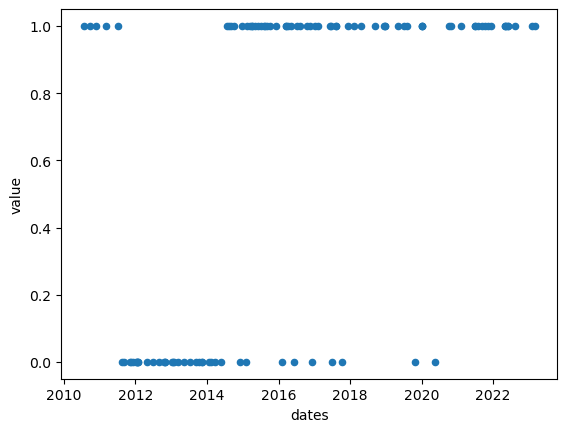

In [9]:
show_completenes()

## Trend Graph

In [10]:
cpu_cnts = dict()
for cnt in cnt_represented:
    cpu_cnts[cnt] = []
dates = [ pd.to_datetime(key) for key in cpu_info if not cpu_info[key][0] == "failed" ]
for _, pairs in cpu_info.items():
    cnt_available = set()
    if pairs[0] == "failed":
        continue
    for cnt, percentage in pairs:
        cpu_cnts[cnt].append( float(percentage[:-1]))
        cnt_available.add(cnt)
    cnt_missing = cnt_repr - cnt_available
    for cnt in cnt_missing:
        cpu_cnts[cnt].append(0.0)

In [11]:
assert len({ len(cpu_cnts[key]) for key in cpu_cnts} | {len(dates)}) == 1, "unequal length of datasets"

In [12]:
cpu_data = pd.DataFrame()
for cnt, data in cpu_cnts.items():
    cpu_data[cnt] = data
cpu_data["dates"] = dates
cpu_data.set_index("dates", inplace=True)
#cpu_data.drop("dates",axis=1,inplace=True)
#cpu_data.plot(legend=False)

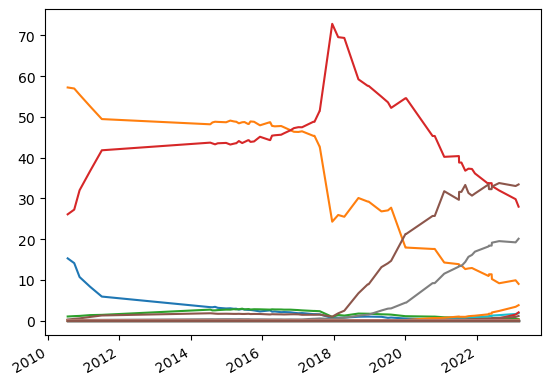

In [13]:
plt.plot(cpu_data)
plt.gcf().autofmt_xdate()
plt.show()

In [13]:
cpu_means = dict()
for cnt in cnt_represented:
    mean = cpu_data[cnt].mean()
    cpu_means[cnt] = mean
#display(cpu_means)

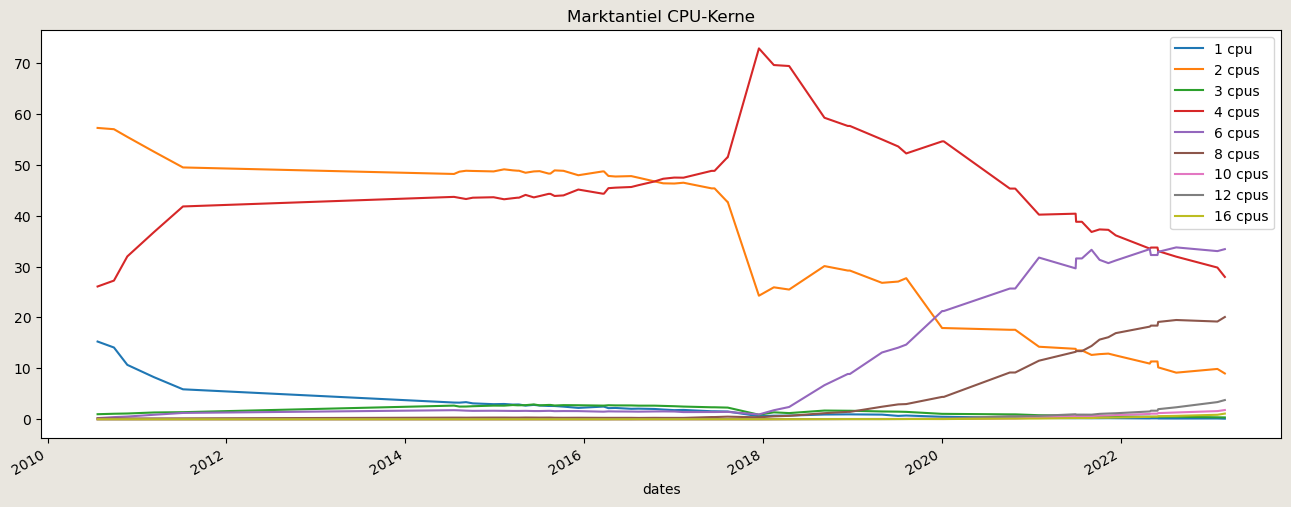

In [56]:
trimmed_data = cpu_data.copy()
#display(trimmed_data)
for cnt, mean in cpu_means.items():
    if mean < 0.1:
        trimmed_data = trimmed_data.drop(cnt,axis=1,)
trimmed_data.plot(title="Marktantiel CPU-Kerne", legend=True,figsize=(16,6),).get_figure().set_facecolor("#e9e6df")

In [21]:
16/9 * 6

10.666666666666666

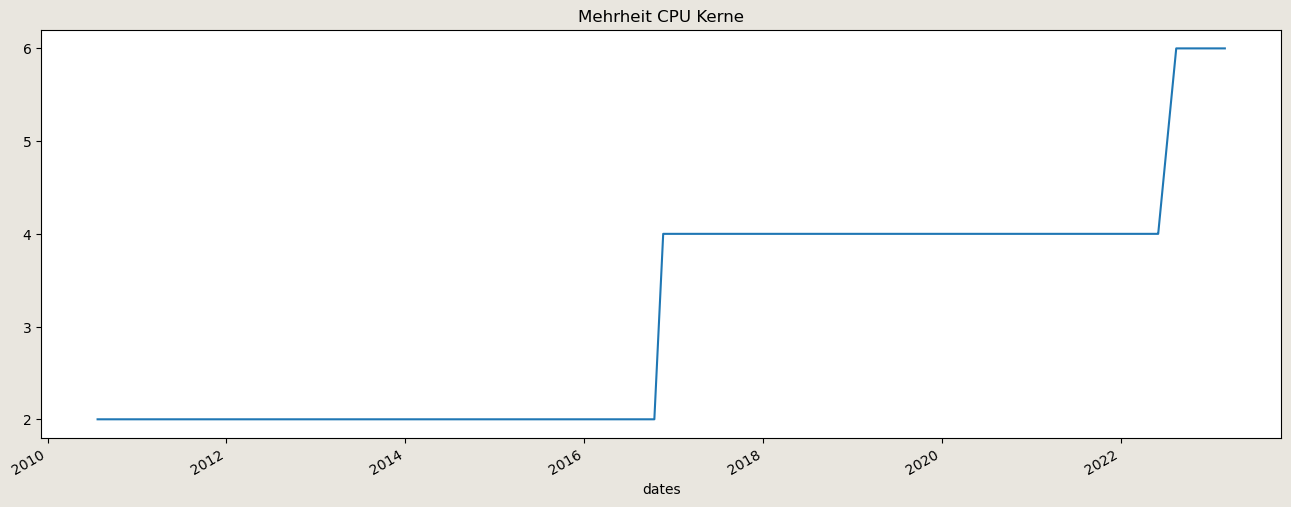

In [19]:
date_max = cpu_data.copy()
date_max.columns = [c.split(' ')[0] for c in date_max.columns]
date_max = pd.DataFrame(date_max.idxmax(axis=1))
date_max[0] = date_max[0].astype("int")
date_max.columns = ["majority count"]
date_max.plot(title = "Mehrheit CPU Kerne" ,legend=False,figsize=(16,6),yticks=np.arange(2,7,1)).get_figure().set_facecolor("#e9e6df")

## Debugging

In [ ]:
bs = None
with snapshots[0].open(encoding="utf8") as f:
        content = f.readlines()
        bs = BeautifulSoup("".join(content))

In [ ]:
heading = bs.find("div", text=re.compile(".*Physical CPUs.*"))

In [ ]:
cpu_list = heading.parent.fetchNextSiblings()[0]
cpu_list

In [ ]:
count_list = cpu_list.findAll(text = re.compile(".*[1234567890]{1,2} cpu.*"))
count_list

In [ ]:
val_list = cpu_list.findAll("div", text = re.compile("\d{1,2}(\.\d{1,2})%.*"))
display(val_list)
val_list = [ val.text for val in val_list if not val.text.startswith(("-","+")) and not "span" in str(val)  ]
val_list

In [ ]:
len(val_list) - len(count_list)

In [ ]:
cpu_instance.parent.parent.next_sibling.next_element.text

In [ ]:
re.compile(".*[1234567890]{1,2} cpu.*").match("41 cpus")

In [ ]:
cpu_info